In [1]:
from importlib.machinery import SourceFileLoader
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [10]:
from skmob.measures.evaluation import nrmse, pearson_correlation, kullback_leibler_divergence, r_squared, rmse, nrmse

In [3]:
np.random.seed(42)

In [4]:
def common_part_of_commuters(values1, values2, numerator_only=False):
    if numerator_only:
        tot = 1.0
    else:
        tot = (np.sum(values1) + np.sum(values2))
    if tot > 0:
        return 2.0 * np.sum(np.minimum(values1, values2)) / tot
    else:
        return 0.0

In [38]:
path = './utils.py'
utils = SourceFileLoader('utils', path).load_module()
path = './data_loader.py'
dgd = SourceFileLoader('dg_data', path).load_module()

db_dir = './data/houston'
dataset = 'houston'

model_dict = {}

subgroup_list = ["Under $50K", "$50K - $100K", "$100K - $200K", "Over $200K"]

for selected_subgroup_cate in subgroup_list + ["all"]:
    tileid2oa2features2vals, oa_gdf, flow_df, oa2pop, oa2features, od2flow, oa2centroid = utils.load_data(db_dir,
                                                                                                          'tile_ID',
                                                                                                          'geometry',
                                                                                                          'GEOID',
                                                                                                          'geometry',
                                                                                                          'geoid_o',
                                                                                                          'geoid_d',
                                                                                                          'pop_flows',
                                                                                                          selected_subgroup_cate,
                                                                                                         recalculate_data = 0)
    oa2features = {oa: np.concatenate((np.log([oa2pop[oa]]), feats)) for oa, feats in oa2features.items()}
    o2d2flow = {}
    for (o, d), f in od2flow.items():
        try:
            d2f = o2d2flow[o]
            d2f[d] = f
        except KeyError:
            o2d2flow[o] = {d: f}
    model_type = 'DG'
    experiment_visitors = 1
    train_data = [oa for t in pd.read_csv(db_dir + '/processed/train_tiles.csv', header=None, dtype=object)[0].values for oa
                  in tileid2oa2features2vals[str(t)].keys()]
    test_data = [oa for t in pd.read_csv(db_dir + '/processed/test_tiles.csv', header=None)[0].values for oa in
                 tileid2oa2features2vals[str(t)].keys()]
    total_data = train_data + test_data
    
    train_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': experiment_visitors}
    test_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': experiment_visitors}
    
    train_dataset = dgd.FlowDataset(train_data, **train_dataset_args)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    test_dataset = dgd.FlowDataset(test_data, **test_dataset_args)
    total_dataset = dgd.FlowDataset(total_data, **test_dataset_args)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    
    dim_input = len(train_dataset.get_features(train_data[0], train_data[2]))
    train_features = np.array([total_dataset[i][0][0] for i in range(len(total_dataset))]).reshape(len(total_dataset) * 30, dim_input)

    ss = StandardScaler()
    ss.fit(train_features)

    device = torch.device("cuda")
    model_list = []
    for round in range(1, 6):
        model = utils.load_model(f'./results/model_{model_type}_{dataset}_{selected_subgroup_cate}_round_{round}.pt', oa2centroid, oa2features, oa2pop, dim_s=dim_input, device=device)
        model_list.append(model)
        
    model_dict[selected_subgroup_cate] = {
        "test_dataset": test_dataset,
        "ss": ss,
        "model": model_list
    }

./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In

In [6]:
values = list(oa2pop.values())
quantiles = np.quantile(values, np.linspace(0, 1, 11))

quantile_dict = {key: np.digitize(value, quantiles) for key, value in oa2pop.items()}

In [39]:
from scipy import stats
from scipy.spatial import distance

all_test_loader = torch.utils.data.DataLoader(model_dict["all"]["test_dataset"], batch_size=1)

res_log_list = []
cpc_by_quantile = dict(zip(range(1, 11), [[] for _ in range(10)]))

for round_idx in range(5):
    cpc_list = []
    target_flow_list = []
    predicted_flow_list = []
    for batch_idx, all_data_temp in enumerate(all_test_loader):
        all_b_data = all_data_temp[0]
        all_b_target = all_data_temp[1]
        geoid = all_data_temp[2][0][0]
        quantile = quantile_dict[geoid]
        
        for sample_idx in range(len(all_b_data)):
            sample_target = all_b_target[sample_idx]
            if sample_target.sum() == 0:
                continue
    
            agg_target = []
            agg_output = []
            for subgroup in subgroup_list:
                subgroup_data_temp = model_dict[subgroup]["test_dataset"].__getitem__(batch_idx)
                subgroup_ss = model_dict[subgroup]["ss"]
                subgroup_model = model_dict[subgroup]["model"][round_idx]
                
                subgroup_data = subgroup_data_temp[0][sample_idx]
                subgroup_target = subgroup_data_temp[1][sample_idx]
    
                subgroup_data = torch.tensor([subgroup_ss.transform(subgroup_data)]).float()
    
                output = subgroup_model.forward(subgroup_data)
                subgroup_test_model = subgroup_model.get_flatten_test_model(subgroup_data, subgroup_target)
    
                agg_target.append(subgroup_target)
                agg_output.append(subgroup_test_model)
    
            cpc = common_part_of_commuters(sum(agg_target).numpy(), sum(agg_output))
            cpc_by_quantile[quantile].append(cpc)
            cpc_list.append(cpc)
            target_flow_list.extend(sum(agg_target).tolist())
            predicted_flow_list.extend(sum(agg_output).tolist())

    cpc_mean = np.mean(cpc_list)
    corr = stats.pearsonr(target_flow_list, predicted_flow_list)[0]
    jsd = distance.jensenshannon(target_flow_list, predicted_flow_list)
    rmse_val = rmse(target_flow_list, predicted_flow_list)
    nrmse_val = rmse(target_flow_list, predicted_flow_list) / (max(target_flow_list) - min(target_flow_list))
    
    res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    print("social groups + visitors CPC", np.mean(cpc_list), np.std(cpc_list))
    print("social groups + visitors Corr", stats.pearsonr(target_flow_list, predicted_flow_list))
    print("social groups + visitors JSD", distance.jensenshannon(target_flow_list, predicted_flow_list))
    print("social groups + visitors RMSE", rmse(target_flow_list, predicted_flow_list))

social groups + visitors CPC 0.6200151124219456 0.08882355361597077
social groups + visitors Corr PearsonRResult(statistic=0.7717362953281123, pvalue=0.0)
social groups + visitors JSD 0.3489318010947672
social groups + visitors RMSE 198.93386482047677
social groups + visitors CPC 0.6176088038530336 0.08740326480315552
social groups + visitors Corr PearsonRResult(statistic=0.7607708865881673, pvalue=0.0)
social groups + visitors JSD 0.35331695270127006
social groups + visitors RMSE 206.72390258461948
social groups + visitors CPC 0.6195341195374542 0.08806321329152517
social groups + visitors Corr PearsonRResult(statistic=0.7711484372768048, pvalue=0.0)
social groups + visitors JSD 0.349585696865002
social groups + visitors RMSE 200.12789222427932
social groups + visitors CPC 0.6197374181777693 0.08709765501542617
social groups + visitors Corr PearsonRResult(statistic=0.7791107631397836, pvalue=0.0)
social groups + visitors JSD 0.34929672836860864
social groups + visitors RMSE 199.605693

In [41]:
pd.DataFrame(res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.619717,0.773258,0.349717,200.024799,0.006884
std,0.001454,0.008693,0.002173,4.308751,0.000148
min,0.617609,0.760771,0.347456,194.732642,0.006701
25%,0.619534,0.771148,0.348932,198.933865,0.006846
50%,0.619737,0.771736,0.349297,199.605693,0.006869
75%,0.620015,0.779111,0.349586,200.127892,0.006887
max,0.621690,0.783522,0.353317,206.723903,0.007114


In [46]:
all_ss = model_dict["all"]["ss"]
all_res_log_list = []

for round_idx in range(5):
    all_cpc_list = []
    all_target_flow_list = []
    all_predicted_flow_list = []
    for batch_idx, data_temp in enumerate(all_test_loader):
        b_data = data_temp[0]
        b_target = data_temp[1]
        ids = data_temp[2]
    
        all_model = model_dict["all"]["model"][round_idx]
        for data, target in zip(b_data, b_target):
            if target.sum() == 0:
                continue
            data = torch.tensor([all_ss.transform(data[0])]).float()
            output = all_model.get_flatten_test_model(data, target)
            cpc = common_part_of_commuters(sum(target).numpy(), output)
            all_cpc_list.append(cpc)
            all_target_flow_list.extend(sum(target).tolist())
            all_predicted_flow_list.extend(output.tolist())

    cpc_mean = np.mean(all_cpc_list)
    corr = stats.pearsonr(all_target_flow_list, all_predicted_flow_list)[0]
    jsd = distance.jensenshannon(all_target_flow_list, all_predicted_flow_list)
    rmse_val = rmse(all_target_flow_list, all_predicted_flow_list)
    nrmse_val = rmse(all_target_flow_list, all_predicted_flow_list) / (max(all_target_flow_list) - min(all_target_flow_list))

    all_res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    print("No social groups + visitors CPC", np.mean(all_cpc_list), np.std(all_cpc_list))
    print("No social groups + visitors Corr", stats.pearsonr(all_target_flow_list, all_predicted_flow_list))
    print("No social groups + visitors JSD", distance.jensenshannon(all_target_flow_list, all_predicted_flow_list))
    print("No social groups + visitors RMSE", rmse(all_target_flow_list, all_predicted_flow_list))

No social groups + visitors CPC 0.6106780876852785 0.09543612791801168
No social groups + visitors Corr PearsonRResult(statistic=0.6650547503624156, pvalue=0.0)
No social groups + visitors JSD 0.3581850432277611
No social groups + visitors RMSE 221.78047933120476
No social groups + visitors CPC 0.6094022245051145 0.0964063814361196
No social groups + visitors Corr PearsonRResult(statistic=0.6780687500667815, pvalue=0.0)
No social groups + visitors JSD 0.35817404175739354
No social groups + visitors RMSE 218.39168288723735
No social groups + visitors CPC 0.6109389518815411 0.09545137192992623
No social groups + visitors Corr PearsonRResult(statistic=0.6660966696021021, pvalue=0.0)
No social groups + visitors JSD 0.35756967969433334
No social groups + visitors RMSE 221.80927537198608
No social groups + visitors CPC 0.610770947551278 0.09443114021316942
No social groups + visitors Corr PearsonRResult(statistic=0.6500809476786458, pvalue=0.0)
No social groups + visitors JSD 0.3586335691486

In [47]:
pd.DataFrame(all_res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.610561,0.662428,0.358224,222.495774,0.007559
std,0.000661,0.011285,0.000422,2.883879,0.000098
min,0.609402,0.650081,0.357570,218.391683,0.007420
25%,0.610678,0.652837,0.358174,221.780479,0.007535
50%,0.610771,0.665055,0.358185,221.809275,0.007536
75%,0.610939,0.666097,0.358558,224.872437,0.007640
max,0.611015,0.678069,0.358634,225.624993,0.007665


In [48]:
path = './utils.py'
utils = SourceFileLoader('utils', path).load_module()
path = './data_loader.py'
dgd = SourceFileLoader('dg_data', path).load_module()

db_dir = './data/houston'
dataset = 'houston'

device = torch.device("cuda")

no_visitor_model_dict = {}
subgroup_list = ["Under $50K", "$50K - $100K", "$100K - $200K", "Over $200K"]

for selected_subgroup_cate in subgroup_list + ["all"]:
    tileid2oa2features2vals, oa_gdf, flow_df, oa2pop, oa2features, od2flow, oa2centroid = utils.load_data(db_dir,
                                                                                                          'tile_ID',
                                                                                                          'geometry',
                                                                                                          'GEOID',
                                                                                                          'geometry',
                                                                                                          'geoid_o',
                                                                                                          'geoid_d',
                                                                                                          'pop_flows',
                                                                                                          selected_subgroup_cate,
                                                                                                         recalculate_data = 0)
    oa2features = {oa: np.concatenate((np.log([oa2pop[oa]]), feats)) for oa, feats in oa2features.items()}
    o2d2flow = {}
    for (o, d), f in od2flow.items():
        try:
            d2f = o2d2flow[o]
            d2f[d] = f
        except KeyError:
            o2d2flow[o] = {d: f}
    model_type = 'DG'
    experiment_visitors = 0
    train_data1 = [oa for t in pd.read_csv(db_dir + '/processed/train_tiles.csv', header=None, dtype=object)[0].values for oa
                  in tileid2oa2features2vals[str(t)].keys()]
    test_data = [oa for t in pd.read_csv(db_dir + '/processed/test_tiles.csv', header=None)[0].values for oa in
                 tileid2oa2features2vals[str(t)].keys()]
    total_data = train_data + test_data
    
    train_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': 0}
    test_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': 0}
    
    train_dataset = dgd.FlowDataset(train_data, **train_dataset_args)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    test_dataset = dgd.FlowDataset(test_data, **test_dataset_args)
    total_dataset = dgd.FlowDataset(total_data, **test_dataset_args)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    
    dim_input = len(train_dataset.get_features(train_data[0], train_data[2]))
    train_features = np.array([total_dataset[i][0][0] for i in range(len(total_dataset))]).reshape(len(total_dataset) * 30, dim_input)

    ss = StandardScaler()
    ss.fit(train_features)
    model_list = []
    for round in range(1, 6):
        model = utils.load_model(f'./results/model_{model_type}_{dataset}_{selected_subgroup_cate}_round_{round}_no_visitors.pt', oa2centroid, oa2features, oa2pop, dim_s=dim_input, device=device)
        model_list.append(model)
        
    no_visitor_model_dict[selected_subgroup_cate] = {
        "test_dataset": test_dataset,
        "ss": ss,
        "model": model_list
    }

./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In

In [49]:
from scipy import stats
from scipy.spatial import distance

all_test_loader = torch.utils.data.DataLoader(no_visitor_model_dict["all"]["test_dataset"], batch_size=1)
no_visitor_res_log_list = []

for round_idx in range(5):
    no_visitor_cpc_list = []
    no_visitor_target_flow_list = []
    no_visitor_predicted_flow_list = []
    for batch_idx, all_data_temp in enumerate(all_test_loader):
        all_b_data = all_data_temp[0]
        all_b_target = all_data_temp[1]
    
        for sample_idx in range(len(all_b_data)):
            sample_target = all_b_target[sample_idx]
            if sample_target.sum() == 0:
                continue
    
            agg_target = []
            agg_output = []
            for subgroup in subgroup_list:
                subgroup_data_temp = no_visitor_model_dict[subgroup]["test_dataset"].__getitem__(batch_idx)
                subgroup_ss = no_visitor_model_dict[subgroup]["ss"]
                subgroup_model = no_visitor_model_dict[subgroup]["model"][round_idx]
                
                subgroup_data = subgroup_data_temp[0][sample_idx]
                subgroup_target = subgroup_data_temp[1][sample_idx]
    
                subgroup_data = torch.tensor([subgroup_ss.transform(subgroup_data)]).float()
    
                output = subgroup_model.forward(subgroup_data)
                subgroup_test_model = subgroup_model.get_flatten_test_model(subgroup_data, subgroup_target)
    
                agg_target.append(subgroup_target)
                agg_output.append(subgroup_test_model)
    
            cpc = common_part_of_commuters(sum(agg_target).numpy(), sum(agg_output))
            no_visitor_cpc_list.append(cpc)
            no_visitor_target_flow_list.extend(sum(agg_target).tolist())
            no_visitor_predicted_flow_list.extend(sum(agg_output).tolist())

    cpc_mean = np.mean(no_visitor_cpc_list)
    corr = stats.pearsonr(no_visitor_target_flow_list, no_visitor_predicted_flow_list)[0]
    jsd = distance.jensenshannon(no_visitor_target_flow_list, no_visitor_predicted_flow_list)
    rmse_val = rmse(no_visitor_target_flow_list, no_visitor_predicted_flow_list)
    nrmse_val = rmse(no_visitor_target_flow_list, no_visitor_predicted_flow_list) / (max(no_visitor_target_flow_list) - min(no_visitor_target_flow_list))

    no_visitor_res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    
    print("social groups + No visitors CPC", np.mean(no_visitor_cpc_list), np.std(no_visitor_cpc_list))
    print("social groups + No visitors Corr", stats.pearsonr(no_visitor_target_flow_list, no_visitor_predicted_flow_list))
    print("social groups + No visitors JSD", distance.jensenshannon(no_visitor_target_flow_list, no_visitor_predicted_flow_list))

social groups + No visitors CPC 0.6129140149636472 0.08676884973728953
social groups + No visitors Corr PearsonRResult(statistic=0.7351581343445317, pvalue=0.0)
social groups + No visitors JSD 0.3568622818292834
social groups + No visitors CPC 0.6128021586079593 0.08689475320087184
social groups + No visitors Corr PearsonRResult(statistic=0.7359695001127919, pvalue=0.0)
social groups + No visitors JSD 0.35637720145148827
social groups + No visitors CPC 0.6124635924317963 0.08638905176935832
social groups + No visitors Corr PearsonRResult(statistic=0.7371783802300286, pvalue=0.0)
social groups + No visitors JSD 0.3566505447146931
social groups + No visitors CPC 0.6120305802631769 0.08732457479037917
social groups + No visitors Corr PearsonRResult(statistic=0.7337789627573905, pvalue=0.0)
social groups + No visitors JSD 0.3566754489895748
social groups + No visitors CPC 0.6124795433270368 0.08754913641412365
social groups + No visitors Corr PearsonRResult(statistic=0.73889205091674, pval

In [50]:
pd.DataFrame(no_visitor_res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.612538,0.736195,0.356471,210.479398,0.007243
std,0.000346,0.001950,0.000419,1.267873,0.000044
min,0.612031,0.733779,0.355789,208.614341,0.007179
25%,0.612464,0.735158,0.356377,210.287777,0.007237
50%,0.612480,0.735970,0.356651,210.582827,0.007247
75%,0.612802,0.737178,0.356675,210.750128,0.007253
max,0.612914,0.738892,0.356862,212.161915,0.007301


In [52]:
no_visitors_all_ss = no_visitor_model_dict["all"]["ss"]
no_visitors_all_res_log_list = []
no_visitors_all_cpc_by_quantile = dict(zip(range(1, 11), [[] for _ in range(10)]))

for round_idx in range(5):
    no_visitors_all_cpc_list = []
    no_visitors_all_target_flow_list = []
    no_visitors_all_predicted_flow_list = []
    for batch_idx, data_temp in enumerate(all_test_loader):
        b_data = data_temp[0]
        b_target = data_temp[1]
        geoid = data_temp[2][0][0]
        quantile = quantile_dict[geoid]
        
        all_model = no_visitor_model_dict["all"]["model"][round_idx]
        for data, target in zip(b_data, b_target):
            if target.sum() == 0:
                continue
            data = torch.tensor([no_visitors_all_ss.transform(data[0])]).float()
            output = all_model.get_flatten_test_model(data, target)
            cpc = all_model.get_cpc(data, target)
            no_visitors_all_cpc_by_quantile[quantile].append(cpc)
            no_visitors_all_cpc_list.append(cpc)
            no_visitors_all_target_flow_list.extend(sum(target).tolist())
            no_visitors_all_predicted_flow_list.extend(output.tolist())

    cpc_mean = np.mean(no_visitors_all_cpc_list)
    corr = stats.pearsonr(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list)[0]
    jsd = distance.jensenshannon(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list)
    rmse_val = rmse(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list)
    nrmse_val = rmse(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list) / (max(no_visitors_all_target_flow_list) - min(no_visitors_all_target_flow_list))

    no_visitors_all_res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    
    print("No social groups + No visitors CPC", np.mean(no_visitors_all_cpc_list), np.std(no_visitors_all_cpc_list))
    print("No social groups + No visitors Corr", stats.pearsonr(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list))
    print("No social groups + No visitors JSD", distance.jensenshannon(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list))

No social groups + No visitors CPC 0.5983802157948609 0.10107912035948888
No social groups + No visitors Corr PearsonRResult(statistic=0.6077258803828759, pvalue=0.0)
No social groups + No visitors JSD 0.36838646417429954
No social groups + No visitors CPC 0.5955530753821323 0.10237064338585666
No social groups + No visitors Corr PearsonRResult(statistic=0.6106030255588628, pvalue=0.0)
No social groups + No visitors JSD 0.37001564182525815
No social groups + No visitors CPC 0.5966234594842964 0.10015010231795334
No social groups + No visitors Corr PearsonRResult(statistic=0.6043387333265323, pvalue=0.0)
No social groups + No visitors JSD 0.3694462445525811
No social groups + No visitors CPC 0.598390295795775 0.10058433893235301
No social groups + No visitors Corr PearsonRResult(statistic=0.6086712286213519, pvalue=0.0)
No social groups + No visitors JSD 0.3682706301369298
No social groups + No visitors CPC 0.5990130213675916 0.10088772601694414
No social groups + No visitors Corr Pears

In [53]:
pd.DataFrame(no_visitors_all_res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.597592,0.611780,0.368630,230.547092,0.007833
std,0.001447,0.009110,0.001155,2.060790,0.000070
min,0.595553,0.604339,0.367030,227.022488,0.007713
25%,0.596623,0.607726,0.368271,230.569807,0.007833
50%,0.598380,0.608671,0.368386,231.356768,0.007860
75%,0.598390,0.610603,0.369446,231.516042,0.007866
max,0.599013,0.627562,0.370016,232.270356,0.007891


In [93]:
np.array([res_log_list, all_res_log_list, no_visitor_res_log_list, no_visitors_all_res_log_list]).mean(axis=1)

array([[  0.61971711,   0.77325764,   0.34971749, 200.02479892],
       [  0.61056112,   0.66242758,   0.35822403, 222.49577365],
       [  0.54638702,   0.73619541,   0.35647088, 210.47939762],
       [  0.59759201,   0.61178024,   0.36862981, 230.54709237]])

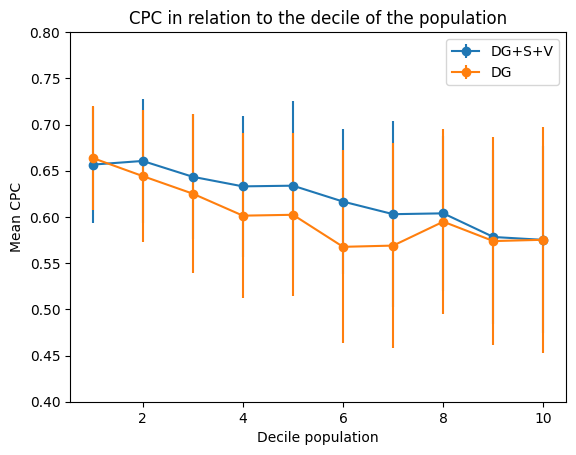

In [86]:
import matplotlib.pyplot as plt

def plot_error_bars(data, label):
    keys = data.keys()
    means = [np.mean(values) for values in data.values()]
    stds = [np.std(values) for values in data.values()]
    plt.errorbar(keys, means, yerr=stds, fmt='-o', capsize=0, label=label)

# Plotting
plot_error_bars(cpc_by_quantile, 'DG+S+V')
plot_error_bars(no_visitors_all_cpc_by_quantile, 'DG')

plt.xlabel('Decile population')
plt.ylabel('Mean CPC')
plt.ylim(0.4, 0.8)  # Adjusted to ensure y-axis starts from 0
plt.title('CPC in relation to the decile of the population')
plt.legend()
plt.show()

Text(0, 0.5, 'Relative Improvement (%)')

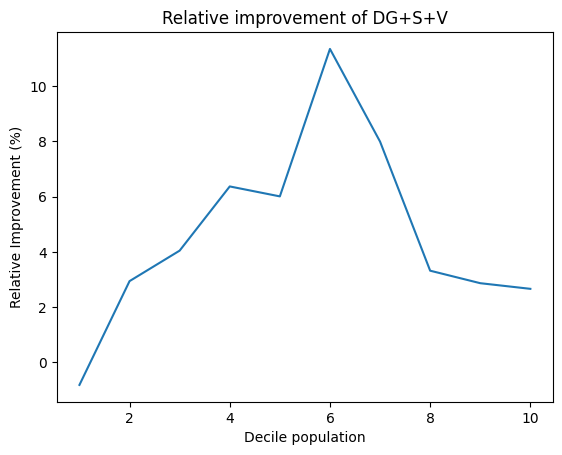

In [89]:
plt.plot(cpc_by_quantile.keys(), [((np.array(cpc_by_quantile[q]) - np.array(no_visitors_all_cpc_by_quantile[q])) / np.array(no_visitors_all_cpc_by_quantile[q]) * 100).mean() for q in range(1, 11)])
plt.title('Relative improvement of DG+S+V')
plt.xlabel('Decile population')
plt.ylabel('Relative Improvement (%)')